In [16]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from skopt import gp_minimize
import warnings
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
warnings.filterwarnings(action='ignore')

In [2]:
hotels = pd.read_csv('hotel.csv')

In [3]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [4]:
hotels.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [5]:
numCols = [col for col in hotels.columns if hotels[col].dtype != 'object']
catCols= [col for col in hotels.columns if hotels[col].dtype == 'object']

numFeatures = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]

catFeatures =[
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]


hotelsCp = hotels.copy()

#colsToDrop = [col for col in catCols if col not in catFeatures]
colsToDrop = ['country','assigned_room_type','reservation_status_date','reservation_status','agent', 'company']
hotelsCp.drop(colsToDrop, axis = 1, inplace=True)

hotelsCp['arrival_date_month'] = \
    hotelsCp['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12})

X = hotelsCp.drop('is_canceled', axis=1)
y = hotelsCp.pop('is_canceled')

scaler = StandardScaler()
encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')
imputer = SimpleImputer(strategy='constant')
catImputer = SimpleImputer(strategy='constant', fill_value="NA")

X_train, X_valid, y_train, y_valid = train_test_split(X,y, train_size=0.75)

#First we imput missing values

X_train[numFeatures] = imputer.fit_transform(X_train[numFeatures])
X_valid[numFeatures] = imputer.transform(X_valid[numFeatures])

X_train[catFeatures] = catImputer.fit_transform(X_train[catFeatures])
X_valid[catFeatures] = catImputer.transform(X_valid[catFeatures])

X_train[numFeatures] = scaler.fit_transform(X_train[numFeatures])
X_valid[numFeatures] = scaler.transform(X_valid[numFeatures])

dfTrainCat = pd.DataFrame(encoder.fit_transform(X_train[catFeatures]),index = X_train.index)
dfValidCat = pd.DataFrame(encoder.transform(X_valid[catFeatures]),index = X_valid.index)

X_train.drop(catFeatures, axis=1,inplace=True)
X_valid.drop(catFeatures, axis=1, inplace=True)

X_train = pd.concat([X_train, dfTrainCat], axis=1)
X_valid = pd.concat([X_valid, dfValidCat], axis =1)

In [6]:
listaNas = []
for col in X_train.columns:
    if X_train[col].isna().sum()>0:
        listaNas.append(col)
listaNas


[]

Epoch 1/200
175/175 [==============================] - 3s 14ms/step - loss: 0.4691 - binary_accuracy: 0.7814 - val_loss: 7.3364 - val_binary_accuracy: 0.6273
Epoch 2/200
175/175 [==============================] - 2s 14ms/step - loss: 0.4061 - binary_accuracy: 0.8100 - val_loss: 2.1619 - val_binary_accuracy: 0.6282
Epoch 3/200
175/175 [==============================] - 2s 14ms/step - loss: 0.3922 - binary_accuracy: 0.8182 - val_loss: 0.7646 - val_binary_accuracy: 0.7309
Epoch 4/200
175/175 [==============================] - 2s 14ms/step - loss: 0.3832 - binary_accuracy: 0.8235 - val_loss: 0.4172 - val_binary_accuracy: 0.7927
Epoch 5/200
175/175 [==============================] - 2s 14ms/step - loss: 0.3766 - binary_accuracy: 0.8266 - val_loss: 0.3722 - val_binary_accuracy: 0.8296
Epoch 6/200
175/175 [==============================] - 2s 14ms/step - loss: 0.3705 - binary_accuracy: 0.8299 - val_loss: 0.3700 - val_binary_accuracy: 0.8317
Epoch 7/200
175/175 [==============================]

<AxesSubplot:title={'center':'Accuracy'}>

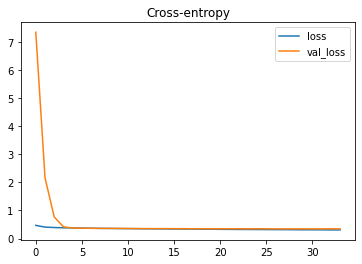

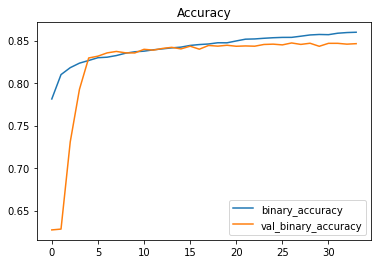

In [74]:
input_shape = [X_train.shape[1]]
dropoutRatio = 0.3

modelNN = keras.Sequential([
    layers.BatchNormalization(input_shape = input_shape),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),   
    layers.Dropout(dropoutRatio),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(dropoutRatio),
    layers.Dense(1,activation='sigmoid')

])

modelNN.compile(optimizer='adam',
    loss = 'binary_crossentropy',
    metrics = ['binary_accuracy'])


early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = modelNN.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],)


history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [8]:
modelRF = RandomForestClassifier(n_estimators=1000,n_jobs=-1)
modelRF.fit(X_train,y_train)

pred = modelRF.predict(X_valid)
print('Acuracia de {}, F1 Score de {}'.format(accuracy_score(y_valid,pred),f1_score(y_valid, pred)))

Acuracia de 0.8662556955239882, F1 Score de 0.807725652634621


In [9]:
def scoreModel(params):


    model = RandomForestClassifier(n_jobs=-1, max_depth=params[0],n_estimators=params[1],min_samples_leaf=params[2], min_samples_split=params[3])
    model.fit(X_train, y_train)

    pred = model.predict(X_valid)
    return -roc_auc_score(y_valid,pred)

In [10]:
params = [
    (2,100),
    (100,2000),
    (1,100),
    (2,100)
]

result = gp_minimize(func = scoreModel,dimensions =params,n_calls=25, n_initial_points=10,random_state=1)

In [11]:
result.x

[61, 1399, 1, 2]

In [13]:
modelRF = RandomForestClassifier(max_depth=61,n_estimators=1700,min_samples_leaf=1, min_samples_split=2,n_jobs=-1)
modelRF.fit(X_train,y_train)

pred = modelRF.predict(X_valid)
roc_auc_score(y_valid,pred)

0.84347253003126

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

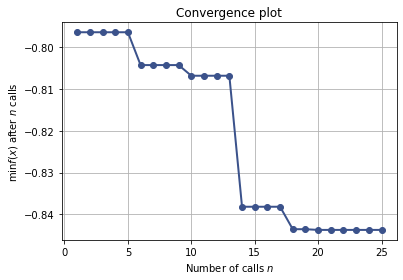

In [14]:
from skopt.plots import plot_convergence

plot_convergence(result)

In [21]:
modelLGB = LGBMClassifier()

cv = cross_val_score(modelLGB,X_train, y_train,scoring='roc_auc',n_jobs=-1)

In [44]:
def scoreLGBM(params):

    model = LGBMClassifier(n_jobs=8, learning_rate = params[0],max_depth = params[1],min_child_samples = params[2],subsample=params[3],colsample_bytree=params[4],
            random_state = 0,n_estimators = 500)

    model.fit(X_train,y_train)

    pred = model.predict(X_valid)
    return -roc_auc_score(y_valid,pred)

In [28]:
help(LGBMClassifier)

Help on class LGBMClassifier in module lightgbm.sklearn:

class LGBMClassifier(sklearn.base.ClassifierMixin, LGBMModel)
 |  LGBMClassifier(boosting_type: str = 'gbdt', num_leaves: int = 31, max_depth: int = -1, learning_rate: float = 0.1, n_estimators: int = 100, subsample_for_bin: int = 200000, objective: Union[str, Callable, NoneType] = None, class_weight: Union[Dict, str, NoneType] = None, min_split_gain: float = 0.0, min_child_weight: float = 0.001, min_child_samples: int = 20, subsample: float = 1.0, subsample_freq: int = 0, colsample_bytree: float = 1.0, reg_alpha: float = 0.0, reg_lambda: float = 0.0, random_state: Union[int, numpy.random.mtrand.RandomState, NoneType] = None, n_jobs: int = -1, silent: Union[bool, str] = 'warn', importance_type: str = 'split', **kwargs)
 |  
 |  LightGBM classifier.
 |  
 |  Method resolution order:
 |      LGBMClassifier
 |      sklearn.base.ClassifierMixin
 |      LGBMModel
 |      sklearn.base.BaseEstimator
 |      builtins.object
 |  
 |  Met

In [41]:
params = [
    (1e-3,0.5,'log-uniform'),  #Learning rate
    (1,100),                   #max_depth
    (1,1000),                  #min_child_samples
    (0.05,1),                   #subsample
    (0.1,1)                     #colsample_bytree
    ]

result = gp_minimize(func = scoreLGBM,dimensions =params,n_calls=50, n_initial_points=10,random_state=1)

In [42]:
result.x

[0.49999999999999994, 78, 585, 1.0, 0.6206097706772015]

In [43]:
modelLGB = LGBMClassifier(n_jobs=8,n_estimators=500,random_state=0, learning_rate=0.5,max_depth=78,min_child_samples=585,subsample=1,colsample_bytree=0.62)

modelLGB.fit(X_train,y_train)

pred = modelLGB.predict(X_valid)

roc_auc_score(y_valid,pred)

0.8329089679400509

In [71]:
def calculaMediaModelos(validSet):
    
    predMod1 = modelRF.predict_proba(validSet)[:,1]
    predMod2 = modelLGB.predict_proba(validSet)[:,1]
    preds = (predMod1+predMod2)/2
    s = lambda a: 1 if a>0.5 else 0
    output = list(map(s,preds))
    return output

In [73]:
predMedia = calculaMediaModelos(X_valid)
roc_auc_score(y_valid,predMedia)

0.8423014222127805

In [75]:
predNN = modelNN.predict(X_valid)
roc_auc_score(y_valid,predNN)

0.9146102246410861

In [78]:
modelNN.save('modelNN.tf')

INFO:tensorflow:Assets written to: modelNN.tf\assets
